# Mountain Car Environment

https://www.gymlibrary.dev/environments/classic_control/mountain_car/


### Handle imports

In [13]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import os
import random
import imageio
#Get progress bars
from tqdm.notebook import trange

#Video
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

#Plotting
import matplotlib.pyplot as plt

In [14]:
#Make our mountai ncar environment
env = gym.make("MountainCar-v0")
print("Observation Space ", env.observation_space)
print("Sample observation", env.observation_space.sample()) #Display a random observation

Observation Space  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Sample observation [-0.54012054  0.03042009]


In [15]:
#Print action space shape and sample
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample())

Action Space Shape 3
Action Space Sample 0


# Video Function
---

In [16]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

# Hyper parameters


In [17]:
num_segments = 20

#Declare a pos space and vel space to divide the area into discrete areas
pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num_segments) #Between -1.2 and 0.6
vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num_segments) #Between -0.07 and 0.07

#Training parameters
num_episodes = 10000
learning_rate = 0.2

#Environment parameters
gamma = 0.99

#Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.05
learn_decay = 0.0005

### Create and Initialize the Q-table

The Q-Table has columns as actions, and rows as states. We can use OpenAI Gym to find action space and state space. We will then use this information to create the Q-Table. 

In [18]:
q_table = np.zeros((len(pos_space), len(vel_space), env.action_space.n)) # Init a 20 x 20 x 3 array
#20 segments of positions, belocity and 3 actions

Epsilon Greedy


In [19]:
def epsilon_greedy_policy(Qtable, state_p, state_v, epsilon):
    random_int = random.uniform(0,1)
    if(random_int > epsilon):
        action = np.argmax(Qtable[state_p, state_v, :])
    else:
        action = env.action_space.sample()
    return action


# Training Function
---

In [20]:
reward_per_episode = np.zeros(num_episodes)

In [21]:
def train_agent(env, num_episodes, min_epsilon, max_epsilon, learning_rate, decay_rate, q_table):  
    for episode in trange(num_episodes):
        #Update epsilon
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        #Reset environment
        state = env.reset()
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        done = False
        totalReward = 0
        while not done:
            #Choose random action for now
            action = epsilon_greedy_policy(q_table, state_p, state_v, epsilon)
            new_state, reward, done, info = env.step(action)
            
            #Find our new state
            new_state_p = np.digitize(new_state[0], pos_space)
            new_state_v = np.digitize(new_state[1], vel_space)
            
            #Update our qtable
            q_table[state_p, state_v, action] = q_table[state_p, state_v, action] + learning_rate * (reward + gamma * np.max(q_table[new_state_p, new_state_v, :]) - q_table[state_p, state_v, action])
                                                                                                     
            state = new_state
            state_p = new_state_p
            state_v = new_state_v
            
            totalReward += reward
            
        reward_per_episode[episode] = totalReward
    return q_table
            

In [25]:
reward_per_episode

array([-200., -200., -200., ..., -200., -150., -200.])

In [22]:
#Train the agent
q_table_car = train_agent(env, num_episodes, min_epsilon, max_epsilon, learning_rate, learn_decay, q_table)

  0%|          | 0/10000 [00:00<?, ?it/s]

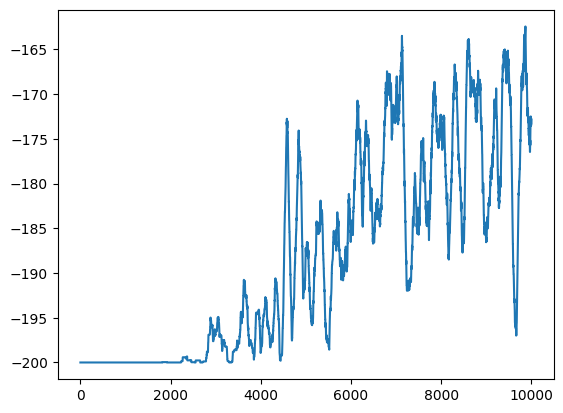

In [23]:
mean_rewards = np.zeros(num_episodes)
for t in range(num_episodes):
    mean_rewards[t] = np.mean(reward_per_episode[max(0, t-100):(t+1)])
plt.plot(mean_rewards)

In [24]:
env = RecordVideo(gym.make("MountainCar-v0"), "./video")
state = env.reset()
state_p = np.digitize(state[0], pos_space)
state_v = np.digitize(state[1], vel_space)
while True:
    env.render()
    #your agent goes here
    action = np.argmax(q_table_car[state_p, state_v, :])
    new_state, reward, done, info = env.step(action)
    new_state_p = np.digitize(state[0], pos_space)
    new_state_v = np.digitize(state[1], vel_space)
    state = new_state
    state_p = new_state_p
    state_v = new_state_v
    if done:
      break;
env.close()
show_video()